# QBI Exercise 12 - Deep Learning
## Authors

- Kevin Mader (mader@biomed.ee.ethz.ch)

## Download Dataset

The training data and ground-truth was supplied by Javier Montoyo (javier.montoya@geod.baug.ethz.ch). 

Go course site and download the 
- ```lab_images.npz``` dataset which contains all of the images

## Import Libraries
Python requires importing libraries and functions you need to access specific tools like science (scipy), linear algebra (numpy), and graphics (matplotlib). These libraries can be installed using the ```pip``` command line tool. Alternatively you can install an python distribution like [Anaconda](https://www.continuum.io/downloads) or [Canopy](https://www.enthought.com/products/canopy/)  which have these and many other standard package pre-installed.

## Deep Learning Libraries
To perform deep learning you will need additional libraries that you will have to install yourself using the ```pip``` tool. These are

### CPU / GPU Computational Engines
- ```theano``` a python-only tool which compiled CPU and GPU code in the background
or 
- ```tensorflow``` a python-wrapper for a C++ tool which uses compiled CPU and GPU code to execute more efficiently

### Frameworks

- ```keras``` a tool that makes constructing and sharing networks much easier that supports theano and tensorflow as underlying computing engines


## Tasks
1. Train the network by running the _fast fit_ chunk a number of times (100 in total)
1. Why does the loss function sometimes show peaks? 
1. What happens when you try to train the network again using the entire dataset, why does the loss go up?
1. How might you make the network better at classifying roads?
1. What effect do the ```MaxPooling2d``` layers have on the output?
1. How can you interpret the kernel values? What might you look for the make sure they are meaningful?
1. What is over-fitting? What can be done to make this less likely to happen? How would you do that with these data?

In [120]:
import numpy as np
import skimage.transform
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt # plotting
from skimage.io import imread # read in images
from skimage.segmentation import mark_boundaries # mark labels
from sklearn.metrics import roc_curve, auc # roc curve tools
from skimage.color import label2rgb
import numpy as np # linear algebra / matrices
# make the notebook interactive
from ipywidgets import interact, interactive, fixed 
import ipywidgets as widgets #add new widgets
from IPython.display import display

%matplotlib inline


In [2]:
# load in the image tiles and make the shape correct
with np.load('lab_images.npz') as in_data:
    col_imgs = in_data['col_imgs'].swapaxes(1,3).swapaxes(2,3)
    # normalized floating point version
    fcol_imgs = (col_imgs.astype(np.float32)-127.0)/127
    lab_imgs = np.expand_dims(in_data['lab_imgs'],1)
    # normalized floating point values
    flab_imgs = lab_imgs.astype(np.float32)/255
    fl_flab_imgs = flab_imgs.reshape((lab_imgs.shape[0],-1))
    print('Color Shape',fcol_imgs.shape,'Label Shape',lab_imgs.shape,'Flat label Shape',fl_flab_imgs.shape)

Color Shape (1000, 3, 96, 96) Label Shape (1000, 1, 96, 96) Flat label Shape (1000, 9216)


## Show sample tiles

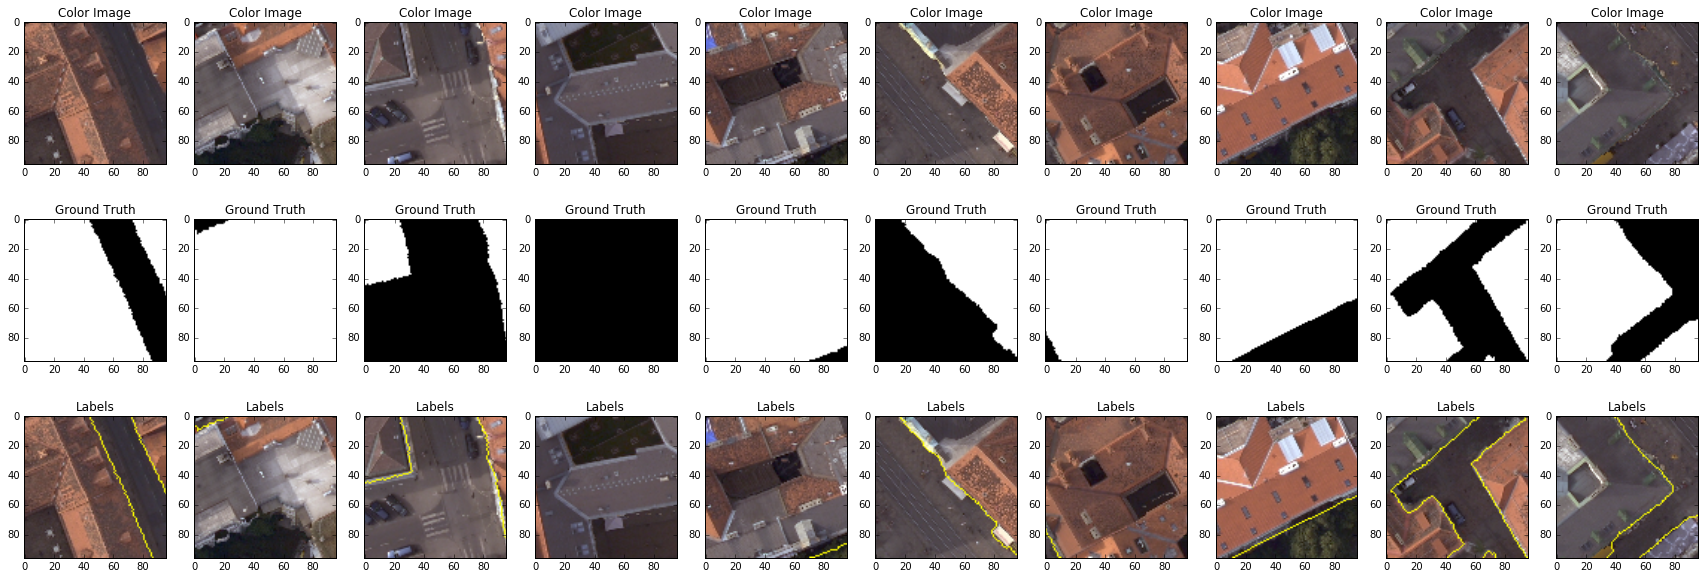

In [3]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(3,10,figsize = (30,10))
for (cax1,wcimg,cax2,wlimg,cax3) in zip(ax1,col_imgs,ax2,lab_imgs,ax3):
    scimg = wcimg.swapaxes(0,2).swapaxes(0,1)
    slimg = wlimg.squeeze()
    cax1.imshow(scimg) # show the color image
    cax1.set_title("Color Image")
    cax2.imshow(slimg, cmap='gray') # show the segments
    cax2.set_title("Ground Truth")
    cax3.imshow(mark_boundaries(scimg,slimg))
    cax3.set_title("Labels")

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
img_cnt, img_channels, img_rows, img_cols = col_imgs.shape
batch_size = 50
# for the first layer
patch_size = 9
depth = 16

DEEPER_LAYER = False
DEEPEST_LAYER = False

In [72]:
model = Sequential()

model.add(Convolution2D(depth, patch_size, patch_size, border_mode='same',
                        input_shape=(img_channels, img_rows, img_cols),
                       W_regularizer = l2(l=0.05)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(3, 3), border_mode='same')) # keep the image size the same


if DEEPER_LAYER:
    model.add(Convolution2D(64, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
if DEEPEST_LAYER:
    model.add(Convolution2D(96, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))    

model.add(Convolution2D(2*depth, 3, 3, border_mode='same',
                       W_regularizer = l2(l=0.02)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same')) 

# combine the channels into output values
model.add(Convolution2D(1, 1, 1, border_mode='same',
                       W_regularizer = l2(l=0.02)))

# upscale the image back to the original size

model.add(UpSampling2D(size=(2, 2))) 
model.add(UpSampling2D(size=(3, 3)))

model.add(Activation('sigmoid')) # bound from zero to one

In [73]:
# overview of network
map(lambda x: (x.name,('in:',x.input_shape[1:],'out:',x.output_shape[1:])),model.layers)

[('convolution2d', ('in:', (3, 96, 96), 'out:', (16, 96, 96))),
 ('activation', ('in:', (16, 96, 96), 'out:', (16, 96, 96))),
 ('dropout', ('in:', (16, 96, 96), 'out:', (16, 96, 96))),
 ('maxpooling2d', ('in:', (16, 96, 96), 'out:', (16, 32, 32))),
 ('convolution2d', ('in:', (16, 32, 32), 'out:', (32, 32, 32))),
 ('activation', ('in:', (32, 32, 32), 'out:', (32, 32, 32))),
 ('maxpooling2d', ('in:', (32, 32, 32), 'out:', (32, 16, 16))),
 ('convolution2d', ('in:', (32, 16, 16), 'out:', (1, 16, 16))),
 ('upsampling2d', ('in:', (1, 16, 16), 'out:', (1, 32, 32))),
 ('upsampling2d', ('in:', (1, 32, 32), 'out:', (1, 96, 96))),
 ('activation', ('in:', (1, 96, 96), 'out:', (1, 96, 96)))]

In [74]:
# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=5e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', # since there are only two classes (road or not)
              optimizer=sgd)

In [134]:
%%time
# a fast fit
# fit the model with the normalized images and the labels
fit_history = model.fit(fcol_imgs[:100,:,:,:],flab_imgs[:100,:],batch_size = batch_size, nb_epoch = 20, shuffle = True)

Epoch 1/20
100/100 [==============================] - 1s - loss: 0.4339     
Epoch 2/20
100/100 [==============================] - 1s - loss: 0.4328     
Epoch 3/20
100/100 [==============================] - 1s - loss: 0.4326     
Epoch 4/20
100/100 [==============================] - 1s - loss: 0.4415     
Epoch 5/20
100/100 [==============================] - 1s - loss: 0.4372     
Epoch 6/20
100/100 [==============================] - 1s - loss: 0.4343     
Epoch 7/20
100/100 [==============================] - 1s - loss: 0.4361     
Epoch 8/20
100/100 [==============================] - 1s - loss: 0.4329     
Epoch 9/20
100/100 [==============================] - 1s - loss: 0.4333     
Epoch 10/20
100/100 [==============================] - 1s - loss: 0.4315     
Epoch 11/20
100/100 [==============================] - 1s - loss: 0.4341     
Epoch 12/20
100/100 [==============================] - 1s - loss: 0.4327     
Epoch 13/20
100/100 [==============================] - 1s - loss: 0.4316 

In [40]:
# fit the model with the normalized images and the labels
fit_history = model.fit(fcol_imgs,flab_imgs,batch_size = batch_size, nb_epoch = 5, shuffle = True)

Epoch 1/5
1000/1000 [==============================] - 16s - loss: 0.4519    
Epoch 2/5
1000/1000 [==============================] - 15s - loss: 0.4508    
Epoch 3/5
1000/1000 [==============================] - 16s - loss: 0.4504    
Epoch 4/5
1000/1000 [==============================] - 15s - loss: 0.4502    
Epoch 5/5
1000/1000 [==============================] - 3256s - loss: 0.4498   


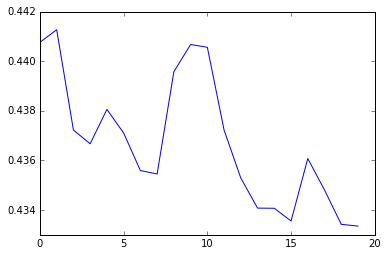

In [126]:
%matplotlib inline
plt.plot(fit_history.history['loss'])

In [127]:
# predict the output layer of the images
pred_fimg = model.predict_on_batch(fcol_imgs)
pred_img = pred_fimg[0].reshape((fcol_imgs.shape[0],lab_imgs.shape[2],lab_imgs.shape[3]))

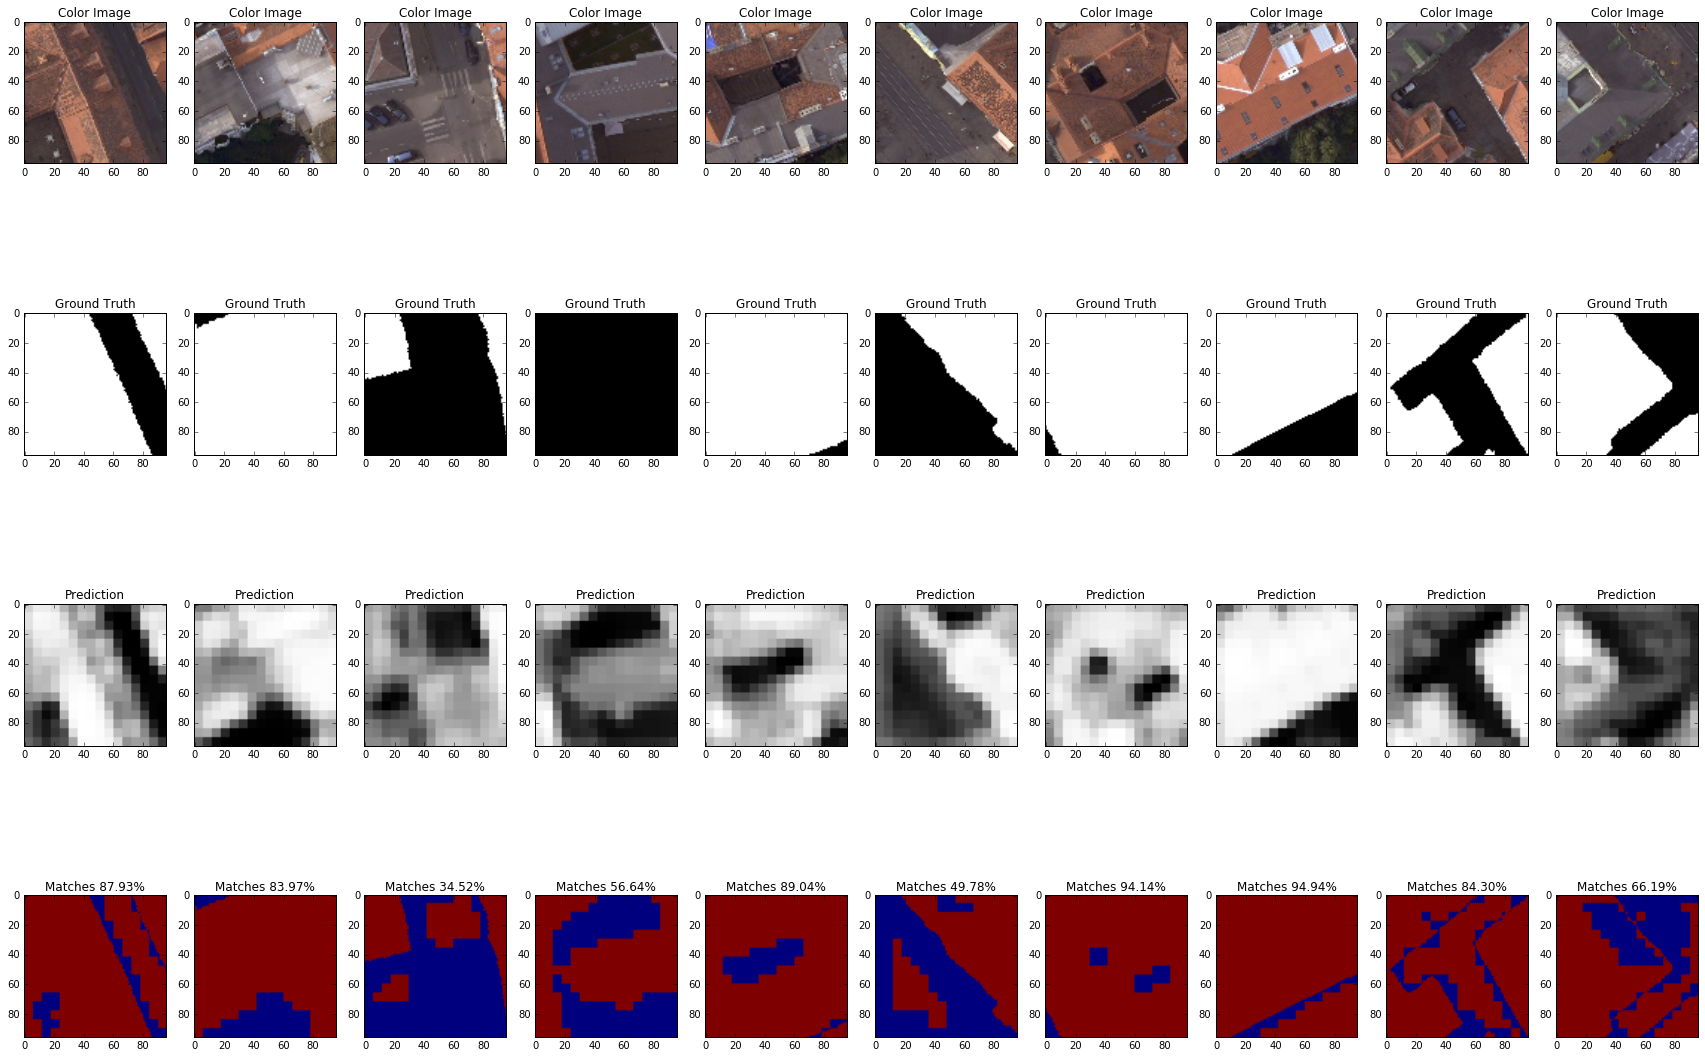

In [128]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,10,figsize = (30,20))
for (cax1,wcimg,cax2,wlimg,cax3,wpimg,cax4) in zip(ax1,col_imgs,ax2,lab_imgs,ax3,pred_img,ax4):
    scimg = wcimg.swapaxes(0,2).swapaxes(0,1)
    slimg = wlimg.squeeze()
    spimg = (wpimg.squeeze()*255).astype(np.uint8)
    cax1.imshow(scimg) # show the color image
    cax1.set_title("Color Image")
    cax2.imshow(slimg, cmap='gray') # show the segments
    cax2.set_title("Ground Truth")
    cax3.imshow(spimg, cmap='gray')
    cax3.set_title("Prediction")
    tp_fn = ((spimg>=127) & (slimg>127))+((spimg<127) & (slimg<127))
    cax4.imshow(tp_fn)
    cax4.set_title("Matches %0.2f%%" % (tp_fn.mean()*100))

## Show some of the learned coefficients / convolution kernels

In [93]:
# overview of overall parameters
parameter_shapes = map(lambda x: (x.name,x.W.get_value().shape+x.b.get_value().shape),
    filter(lambda x: x.__dict__.has_key('W'),model.layers))
print(parameter_shapes)
print('Total Parameters',np.sum([np.prod(p) for (_,p) in parameter_shapes]))

[('convolution2d', (16, 3, 9, 9, 16)), ('convolution2d', (32, 16, 3, 3, 32)), ('convolution2d', (1, 32, 1, 1, 1))]
Total Parameters 209696


We focus just on the first layer since they correspond to the input color images and are easiest to interpret. We see that they show gradients and basic edges. Longer training and more extensive datasets will significantly improve these kernels

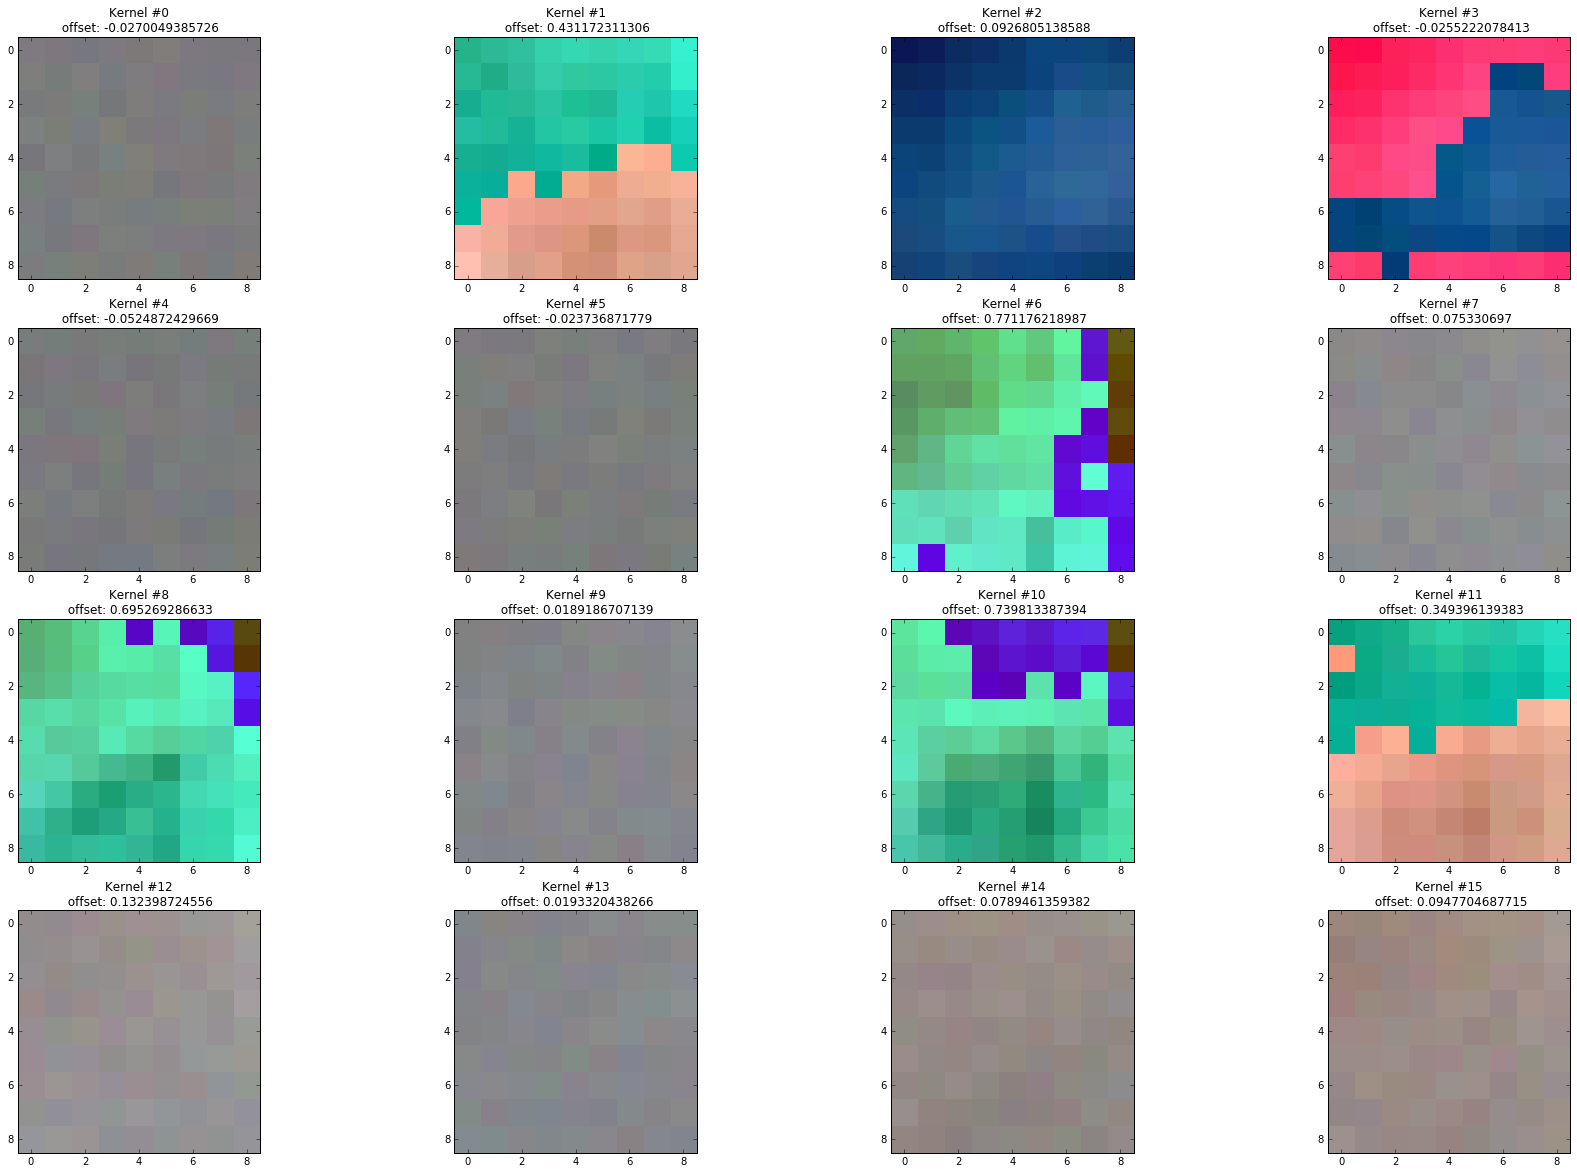

In [135]:
%matplotlib inline
first_weights = model.layers[0].W.get_value()
first_offsets = model.layers[0].b.get_value()
# normalize the values
s_weights = (127*first_weights/(4*np.abs(first_weights).mean())+127).clip(0,255).astype(np.uint8)
fig, ax = plt.subplots(4,4,figsize = (30,20))
for i, (cax, cweights, coffset) in enumerate(zip(ax.flatten(),s_weights,first_offsets)):
    cax.imshow((coffset*127+cweights).astype(np.uint8).swapaxes(0,2).swapaxes(0,1), interpolation = 'nearest')
    cax.set_title('Kernel #{}\n offset: {}'.format(i,coffset))

# Upscaling 
Here we upscale from a small net to a big image. This is one reason why convolutional networks are particularly great. If we had used a fully connected layer ```Dense``` in _keras_ nomenclature, the network would not be scalable, but since it is all convolutional, pooling, and upsampling layers, there is no fixed size dimension in the network. That means we can apply the same analysis to the entire image (1000x1000) by just copying the coefficients to a new network. 
- __Warning__ since we use max pooling and strides, the network has to have a size which is an integer multiple of the total down-sampling. In this case we use 996 instead of 1000 since the total downsampling is x6. 
- For this part you need the two tiff files from the last exercise

In [107]:
big_image = np.expand_dims(imread('ex_im.tif')[0:996,0:996,:].swapaxes(0,2).swapaxes(1,2),0)
fbig_image = (big_image.astype(np.float32) - 127)/127
gt_image = imread('ex_gt.tif')[0:996,0:996]
print('Shape:',big_image.shape,'Ground Truth Shape:',gt_image.shape)

Shape: (1, 3, 996, 996) Ground Truth Shape: (996, 996)


In [108]:
big_model = Sequential()

big_model.add(Convolution2D(depth, patch_size, patch_size, border_mode='same',
                        input_shape=big_image.shape[1:],
                       W_regularizer = l2(l=0.02)))
big_model.add(Activation('relu'))
big_model.add(Dropout(0.25))
big_model.add(MaxPooling2D(pool_size=(3, 3), border_mode='same')) # keep the image size the same


big_model.add(Convolution2D(2*depth, 3, 3, border_mode='same',
                       W_regularizer = l2(l=0.05)))
big_model.add(Activation('relu'))
big_model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same')) 

# combine the channels into output values
big_model.add(Convolution2D(1, 1, 1, border_mode='same',
                       W_regularizer = l2(l=0.05)))

# upscale the image back to the original size

big_model.add(UpSampling2D(size=(2, 2))) 
big_model.add(UpSampling2D(size=(3, 3)))

big_model.add(Activation('sigmoid')) # bound from zero to one
big_model.compile(loss='binary_crossentropy', # since there are only two classes (road or not)
              optimizer=sgd)

In [136]:
# copy the weights from the old to the new
for big_layer,little_layer in zip(big_model.layers,model.layers):
    # convolutional layers
    if little_layer.__dict__.has_key('W'):
        big_layer.W.set_value(little_layer.W.get_value())
        big_layer.b.set_value(little_layer.b.get_value())

In [137]:
# run the network on the big image
pred_big_image = big_model.predict_on_batch(fbig_image)[0]

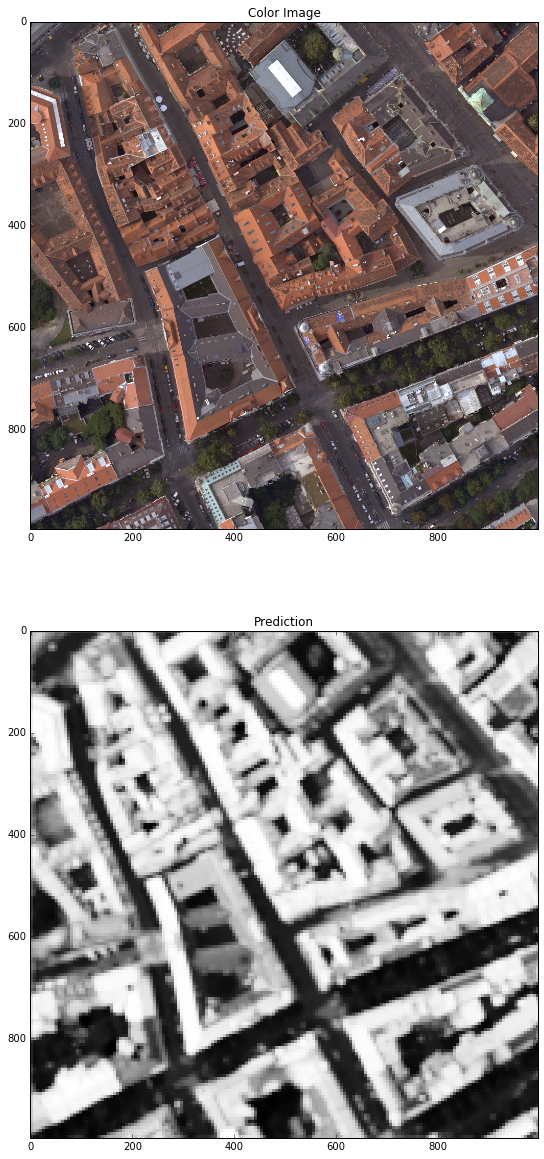

In [138]:
%matplotlib inline

fig, (ax1, ax3) = plt.subplots(2,1,figsize = (30,20))
scimg = big_image[0].swapaxes(0,2).swapaxes(0,1)
spimg = (pred_big_image.squeeze()*255).astype(np.uint8)
ax1.imshow(scimg) # show the color image
ax1.set_title("Color Image")
ax3.imshow(spimg, cmap='gray')
ax3.set_title("Prediction")

## Ground Truth Comparison
Here we show the predictions on top of the ground truth. 
- White values are regions where the values matched closely. 
- Blue indicates the network predicted the output was more building-like than it was.
- Red indicates the network predicted it was more roady than it was.

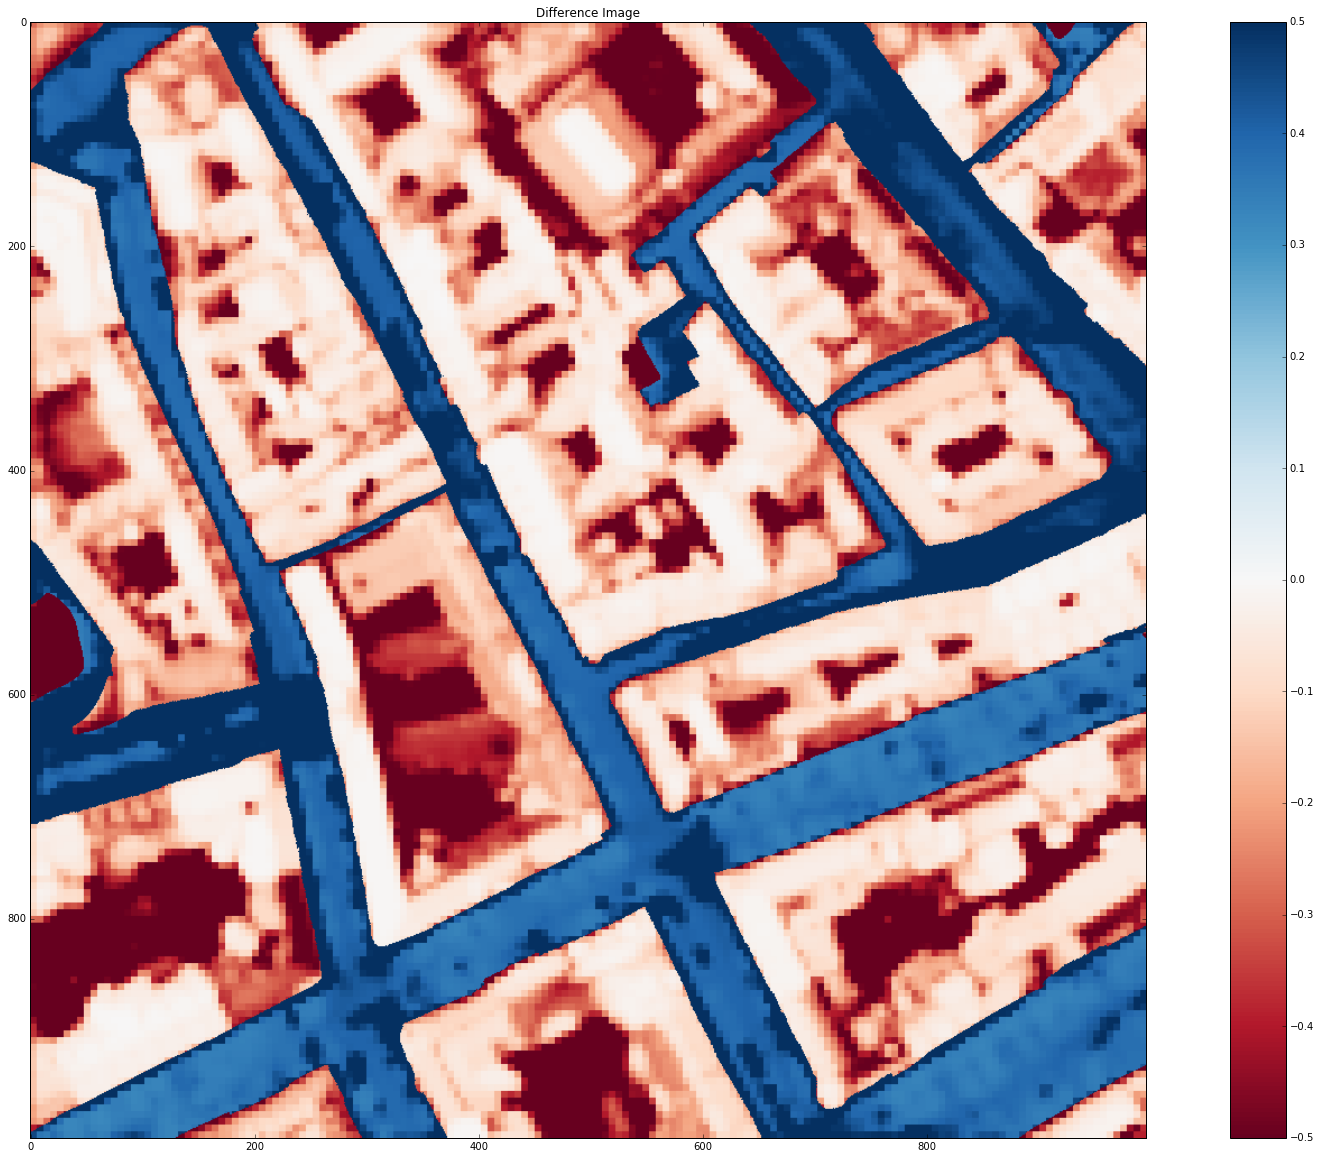

In [139]:
fig, (ax1) = plt.subplots(1,1,figsize = (30,20))
spimg = (pred_big_image.squeeze()-gt_image.astype(np.float32)/255).clip(-.5,.5)

ibar = ax1.imshow(spimg,cmap='RdBu',vmin=-0.5,vmax=0.5) # show the color image
ax1.set_title("Difference Image")
plt.colorbar(ibar)

In [102]:
##TODO copy the model to new model without repeating the code for the layers